# Prototipado rápido con para EDA de PathVQA

In [4]:
# Si estás en Colab o en un kernel local sin la librería 'datasets'
!pip install hf_transfer hf_xet

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 19.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 2.9/2.9 MB 28.1 MB/s eta 0:00:00

   ---------------------------------------- 2/2 [hf_transfer]



## Descargamos y guardamos el dataset PathVQA localmente

In [ ]:
import os
from datasets import load_dataset
import pandas as pd

# 1. Definir rutas relativas al proyecto
project_path = ".."  # Asumiendo que corres esto desde la raíz del proyecto
raw_data_path = os.path.join(project_path, "data", "raw", "path_vqa_hf")

print("Iniciando descarga controlada...")

print(f"El dataset se guardará en: {raw_data_path}")

# 2. Descargar el dataset (primero lo baja a caché temporal)
# Nota: PathVQA es pequeño, así que bajarlo a memoria y luego guardar está bien.
dataset = load_dataset("flaviagiammarino/path-vqa")

print(f"Guardando dataset físicamente en: {raw_data_path}")

# 3. GUARDAR EN EL DIRECTORIO DEL PROYECTO
# Esto crea una carpeta con todos los datos procesados, lista para el clúster.
dataset.save_to_disk(raw_data_path)

print("¡Listo! Dataset guardado y portable.")


### Probamos que se puede cargar offline después

In [ ]:
from datasets import load_from_disk
import os

# Ruta donde ya guardaste los datos
project_path = ".."
raw_data_path = os.path.join(project_path, "data", "raw", "path_vqa_hf")

print(f"Cargando dataset desde: {raw_data_path}")

# Esta es la función que faltaba importar
dataset_offline = load_from_disk(raw_data_path)

print("\n¡Éxito! Estructura del dataset cargado localmente:")
print(dataset_offline)

c:\Users\uzgre\miniconda3\envs\llms-mx-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Cargando dataset desde: ..\data\raw\path_vqa_hf

¡Éxito! Estructura del dataset cargado localmente:
DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 19654
    })
    validation: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 6259
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 6719
    })
})


### Visualizamos algunas muestras del dataset y analizamos estadísticas en los tipos de preguntas

Generando muestras visuales...


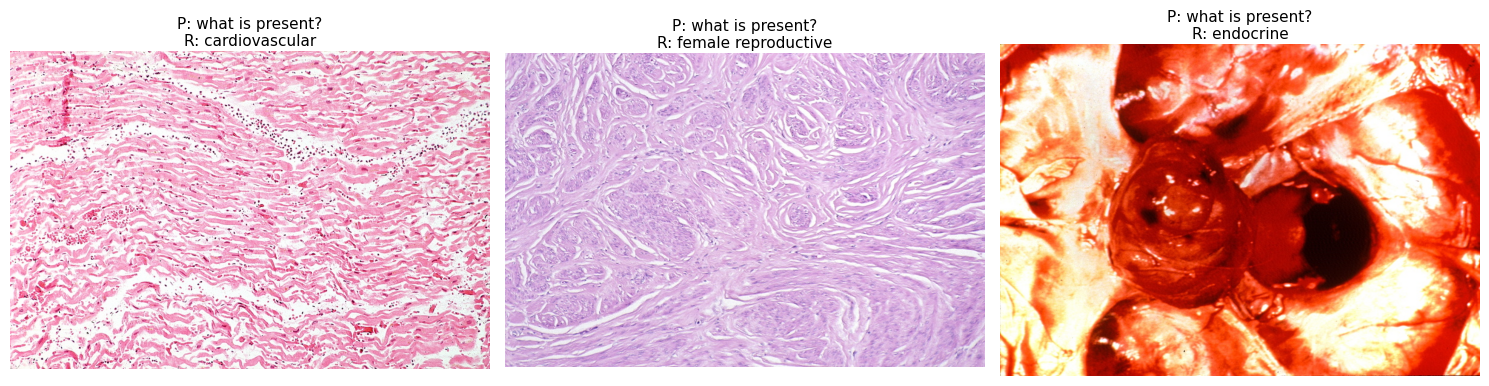


Analizando tipos de respuestas...

--- Distribución (Train Set) ---
tipo
Abierta             9903
Binaria (Yes/No)    9751
Name: count, dtype: int64

--- Porcentajes ---
tipo
Abierta             50.39%
Binaria (Yes/No)    49.61%
Name: proportion, dtype: object


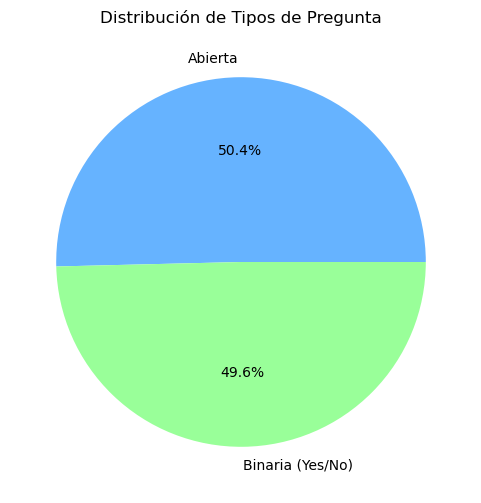

In [ ]:
import matplotlib.pyplot as plt
import random
import pandas as pd

# Usamos el dataset_offline cargado previamente
ds = dataset_offline['train']

# --- 1. Visualización de Muestras ---
def visualizar_muestras(dataset, n=3):
    indices = random.sample(range(len(dataset)), n)
    plt.figure(figsize=(15, 6))

    for i, idx in enumerate(indices):
        item = dataset[idx]
        image = item['image']
        question = item['question']
        answer = item['answer']

        ax = plt.subplot(1, n, i + 1)
        ax.imshow(image)
        ax.axis('off')

        # Formato del texto
        ax.set_title(f"P: {question}\nR: {answer}", fontsize=11, wrap=True)

    plt.tight_layout()
    plt.show()

print("Generando muestras visuales...")
visualizar_muestras(ds)

# --- 2. Estadísticas de Preguntas (Binarias vs Abiertas) ---
print("\nAnalizando tipos de respuestas...")

# Convertimos respuestas a lista para análisis rápido
answers = ds['answer']

# Definimos lógica: Es binaria si la respuesta es exactamente "yes" o "no"
def tipo_pregunta(ans):
    clean_ans = str(ans).lower().strip()
    if clean_ans in ['yes', 'no']:
        return 'Binaria (Yes/No)'
    return 'Abierta'

df_analysis = pd.DataFrame({'answer': answers})
df_analysis['tipo'] = df_analysis['answer'].apply(tipo_pregunta)

# Conteo
conteo = df_analysis['tipo'].value_counts()
porcentajes = df_analysis['tipo'].value_counts(normalize=True) * 100

print("\n--- Distribución (Train Set) ---")
print(conteo)
print("\n--- Porcentajes ---")
print(porcentajes.round(2).astype(str) + '%')

# Gráfica de pastel
plt.figure(figsize=(6, 6))
plt.pie(conteo, labels=conteo.index, autopct='%1.1f%%', colors=['#66b3ff','#99ff99'])
plt.title("Distribución de Tipos de Pregunta")
plt.show()

### Probamos modulo de carga del dataset offline

In [ ]:
import torch
import sys
import os

# Aseguramos que python encuentre tu carpeta src
sys.path.append(os.path.abspath("./src"))

from data.dataset import PathVQADataset  # Importamos tu clase

# --- CLASE MOCK PARA TEST ---
# Simula ser el Processor de LLaVA sin descargar 10GB de cosas
class MockLlavaProcessor:
    def __call__(self, text, images, return_tensors, padding, truncation, max_length):
        print(f"    Processor recibió imagen tamaño: {images.size}")
        print(f"    Processor recibió texto (inicio): {text[:50]}...")

        # Devolvemos tensores falsos (dummy) solo para ver si el código sigue
        return type('obj', (object,), {
            'input_ids': torch.randint(0, 1000, (1, 128)),     # Tokens falsos
            'attention_mask': torch.ones((1, 128)),            # Máscara falsa
            'pixel_values': torch.randn((1, 3, 384, 384))      # Imagen tensor falsa
        })()

# --- EJECUCIÓN DEL TEST ---
print(" Iniciando Test de Dataset...")

# 1. Definir rutas
data_path = "../data/raw/path_vqa_hf" # Donde guardamos el dataset offline
processor_fake = MockLlavaProcessor()

# 2. Instanciar el Dataset
try:
    ds_train = PathVQADataset(data_path, processor=processor_fake, split='train')
    print(f" Dataset instanciado. Tamaño total: {len(ds_train)} ejemplos.")
except Exception as e:
    print(f"Error al instanciar: {e}")
    raise e

# 3. Probar sacar UN elemento (aquí es donde suele fallar si hay errores)
print("\n Intentando leer el índice 0...")
try:
    item = ds_train[0]

    print("\n ¡ÉXITO! Se generó un item con las siguientes llaves:")
    for k, v in item.items():
        print(f"   - {k}: {v.shape} (Tipo: {v.dtype})")

    print("\n Conclusión: Tu dataset.py lee imágenes y formatea el prompt CORRECTAMENTE.")

except Exception as e:
    print(f"\nError al leer item: {e}")
    # Tip de depuración común
    if "load_from_disk" in str(e):
        print(" Tip: Revisa que la ruta ./data/raw/path_vqa_hf exista y tenga archivos .arrow")

In [1]:
print("2. Importando Torch...")
import torch
print(f"   -> Torch version: {torch.__version__}")

2. Importando Torch...


: 

In [ ]:
print("1. Iniciando imports básicos...")
import os
import sys

print("3. Importando Datasets (Hugging Face)...")
from datasets import load_from_disk

print("4. Importando la clase desde tu archivo local...")
sys.path.append(os.path.abspath("../src"))
try:
    from data.dataset import PathVQADataset
    print("   -> Importación exitosa.")
except ImportError as e:
    print(f"   -> Error importando: {e}")
except Exception as e:
    print(f"   -> Otro error al importar: {e}")

print("5. Test de instanciación (Sin procesador)...")
try:
    # Intentamos cargar SOLO los datos, sin el procesador fake aun
    data_path = "./data/raw/path_vqa_hf"
    # Pasamos None al procesador para aislar si el error es la lectura de disco
    ds = PathVQADataset(data_path, processor=None, split='train')
    print(f"   -> Dataset cargado. Longitud: {len(ds)}")
except Exception as e:
    print(f"   -> CRASH o Error aquí: {e}")

print("Si lees esto, el Kernel NO murió.")

1. Iniciando imports básicos...
3. Importando Datasets (Hugging Face)...
4. Importando la clase desde tu archivo local...


: 

## Descargar encoder visual SigLIP 

In [ ]:
from huggingface_hub import snapshot_download

model_id = "google/siglip-so400m-patch14-384"
output_dir = "../checkpoints/siglip_vision_tower"

print(f"Descargando archivos crudos de {model_id}...")

# Esto solo baja archivos, no carga el modelo en memoria.
snapshot_download(
    repo_id=model_id,
    local_dir=output_dir,
    local_dir_use_symlinks=False, # Importante para Windows + Portabilidad
    ignore_patterns=["*.msgpack", "*.h5", "*.tflite"] # Ignoramos pesos de TensorFlow/JAX para ahorrar espacio
)

print(f"¡Listo! Modelo guardado en {output_dir}")

Descargando archivos crudos de google/siglip-so400m-patch14-384...


c:\Users\uzgre\miniconda3\envs\llms-mx-env\lib\site-packages\huggingface_hub\file_download.py:980: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(
Fetching 9 files: 100%|██████████| 9/9 [01:38<00:00, 10.91s/it]

¡Listo! Modelo guardado en ./checkpoints/siglip_vision_tower
